__Tips: Please install Bio before running by:__
pip install biopython

In [423]:
# python3 genome_simulation.py --ini='bacteria.ini' --data='Escherichia_coli_DH10B.fasta'
from configparser import ConfigParser
import optparse
import random, os, sys
import pandas as pd

import logging
from datetime import datetime
import numpy as np
import calendar
import time
from Bio import SeqIO 
from decimal import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import cophenet
pd.options.display.max_columns = None

#### Step 0. Function definition:
__A. parse_file(filename, formatname, length):__ Return the sequencing from file with specified format and length.  
__B. mutate_prob(target_bases_list, prob):__ Mutate the base by picking from bases list with probability.  
__C. mutation_simulate(ori_seq):__ Mutate the original sequencing by probability/flipping and return the mutated sequencing, and how many bases have been mutated.

In [329]:
def parse_file(filename, formatname, length): 
    '''
        filename: file path
        formatname: 'fasta', 'abi', 'genbank or gb' etc...
        length: top number for snipping
    '''
    with open(filename, "rU") as handle:
        for record in SeqIO.parse(handle, formatname) :
            if len(record.seq)>length:
                base_top = record.seq[:length]
        return record, base_top

In [330]:
def mutate_prob(target_bases_list, prob1): 
    picked_base = np.random.choice(target_bases_list, 1, prob1) #Pick 1 from target list based on prob1.
    return picked_base

In [331]:
def mutation_simulate(ori_seq):
    hamming_distance=0
    mutated_seq=[]

    for ori_base in ori_seq:
        flip = np.random.uniform(0, 1)
        #print('flip on ', ori_base, flip)
        
        lambda_list = list(conf_lamba)
        picked_lamba = np.random.choice(lambda_list, 1)
    
        # For C base: transit to A or G by flip probability (if flip < lamda picked randomly from configuration lambda list.)
        if (ori_base == 'C') and (flip <= picked_lamba): #C-> G or A
            mutated_base = mutate_prob(['A','G'], flip)  #Pick 1 from target list based on flip.
            hamming_distance+=1
            if mutated_base:
                #print ('(Mutated', ori_base, ' to: ', mutated_base, ' flip: ', flip, 'lambda: ', picked_lamba, ')')
                mutated_seq.append(mutated_base)   
            else:
                mutated_seq.append(ori_base)
                
        # For G base: transit to C or T by flip probability (if flip < lamda picked randomly from configuration lambda list.)       
        elif (ori_base == 'G') and (flip <= picked_lamba): #G-> C or T
            mutated_base = mutate_prob(['C','T'], flip)  #Pick 1 from target list based on flip.
            hamming_distance+=1
            if mutated_base:
                #print ('(Mutated', ori_base, ' to: ', mutated_base, ' flip: ', flip, 'lambda: ', picked_lamba, ')')
                mutated_seq.append(mutated_base)   
            else:
                mutated_seq.append(ori_base)            
        else:
            mutated_seq.append(ori_base)

    return mutated_seq, hamming_distance

#### Step 1. Please configure these parameters accordingly before running:
- ALL parameters in configuration will be kept in the format of 'conf_XXXXX' for easily recognization.

In [332]:
#[lamba]
# conf_lamba_min/max: It is on a per generation basis ... update mutation rate to different values within the rage. 
# conf_lamba_min/max:Start by one generation the min rate then the next the max rate then the min rate etc
# conf_lamba_min=0.1 
# conf_lamba_max=0.5

# conf_lamba: can have multiple lambas
conf_lamba=0.2,0.1,0.3
conf_generation=7

#[mutation]
# run_times: How many mutated seqs will be generated.
conf_run_times=4 
conf_numrows=1

#[fasta]
# conf_filepath: The path of fasta file.
#conf_filepath = 'C:\Projects\Broad\code\FASTA\Escherichia_coli_DH10B.fasta'
conf_filepath = '../Escherichia_coli_DH10B.fasta'
# conf_top_num: How many bases could be kept from fasta file.
conf_top_num = 40 
# conf_generated_file_format: specify the format will be generated with: '.nex','.txt' etc.
conf_generated_file_format = '.txt'

#### Step 2: Get the specified length of the sequences from the specified file.

In [333]:
# 0. FAKE seq for testing:
# ori_seq='AGCTACTGGC'

In [334]:
# Get the trimmed seq string from specified file.
record, base_top = parse_file(conf_filepath, "fasta", int(conf_top_num))
ori_seq = str(base_top)
print(ori_seq)

AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG


c:\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 'U' mode is deprecated
  import sys


#### Step 3: Generate the mutated sequences with specified times and write these mutated sequeces to file with specified format.
- In this case, write the mutated sequeces in .nex file.  
- The file will be named with timestamp.  
- e.g.: __Generated file: GBAC_<Generation\><mutation_rate\>Seq__  
GBAC_7_0.2 AGCTTTTCATTCTGACTGAAACGGGCAATATGTCTCTGTG  
GBAC_7_0.2 AGATTTTCATTCTGACTGCAACGGTCAATATGTCTCTGTG  
GBAC_7_0.2 AGCTTTTCATTCTGACTGCAACGCGCAATATTTCTATCTC  
GBAC_7_0.2 AGATTTTCATTCTGACTTCAACGCGAAATATGTCTCTGTG  
GBAC_7_0.2 AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG  

In [335]:
# Generate file name with timestamp.
timestamp = calendar.timegm(time.gmtime())
print(timestamp)
mut_seq_nexfilepath = "file_generated\\"+"SimSeqFile_"+ str(timestamp) + conf_generated_file_format

1565640725


#### Step 4: Generate the sequences and differences for output file.

In [336]:
# Sike:
def dna_seq_compare(ori_seq, mutated_seq):
    len1 = len(ori_seq)
    len2 = len(mutated_seq)
    mismatches = []
    diff_pos = []
    
    for pos in range (0, min(len1, len2)):
        if ori_seq[pos]!= mutated_seq[pos]:
            mismatches.append("|")
            diff_pos.append(pos)
        else:
            mismatches.append(" ")
    mismatches = "".join(mismatches)
    return diff_pos, mismatches+'\n'+ mutated_seq

In [406]:
# Create dataframe to store all seqs (original and mutated), hamming distance and the specific difference.
multi_mutated_seq=''
diff_str = ''
multi_mutated_seq ='>Ori\n' + ori_seq+'\n'

list_all_hamming = []
for i in range(0, len(ori_seq)):
    list_all_hamming.append(str(i))
    
df_mutseq_hamming = pd.DataFrame(columns=["id", "seq", "hamming_distance"]+list_all_hamming).append({"id":0,"seq":ori_seq, "hamming_distance":0},ignore_index=True)
df_mutseq_hamming.fillna(0) # Fill the nan value with 0.



,id,seq,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [407]:
# Generate the mutated seq, hamming distance, and mark the difference between mutated seqs and original sequence.
# Generate the dataframe with mutated seq and hamming distance.

for run_time in range(conf_run_times):
    #print('\nMutating...', run_time+1, 'times: ')
    mutated_seq_file_list, hamming_distance = mutation_simulate(ori_seq) #Tuple return: mutation_simulate(): mutated_seq, count. Get mutated_seq.
      
    #seq_num = 'GBAC_' + str(conf_generation)+'_'+ str(conf_lamba)
    mutated_seq = ''.join([''.join(base) for base in mutated_seq_file_list])
    multi_mutated_seq += '>Gen'+str(conf_generation)+'_'+str(run_time)+'\n'+mutated_seq+'\n'
    df_mutseq_hamming = df_mutseq_hamming.append({"id":run_time+1, "seq":mutated_seq, "hamming_distance": hamming_distance},ignore_index=True)
    print('Hamming distance: ', hamming_distance)

    diff_str += str(run_time+1)+' time(s) mutation: '+ str(dna_seq_compare(ori_seq, mutated_seq)[0])+'\n'
    
    #Sike: diff marker:
    print(ori_seq)
    
    str_diff_result = dna_seq_compare(ori_seq, mutated_seq)[1]+'\n'+'_______________________________________'   
    list_diff_result = dna_seq_compare(ori_seq, mutated_seq)[0]
    
    print(str_diff_result)
    
    for diff in list_diff_result:
        print('diff: ', diff)
        df_mutseq_hamming.set_value(run_time+1, str(diff), 1)

Hamming distance:  5
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
 ||                   |          | |    
ACGTTTTCATTCTGACTGCAACTGGCAATATGTATATGTG
_______________________________________
diff:  1
diff:  2
diff:  22
diff:  33
diff:  35
Hamming distance:  6
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
             |    |    ||        | |    
AGCTTTTCATTCTCACTGGAACGTTCAATATGTATATGTG
_______________________________________
diff:  13
diff:  18
diff:  23
diff:  24
diff:  33
diff:  35
Hamming distance:  3
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
  |                   | |               
AGGTTTTCATTCTGACTGCAACCGCCAATATGTCTCTGTG
_______________________________________
diff:  2
diff:  22
diff:  24
Hamming distance:  3
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG
       |              |          |      
AGCTTTTAATTCTGACTGCAACTGGCAATATGTGTCTGTG
_______________________________________
diff:  7
diff:  22
diff:  33


c:\python37\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [408]:
print(diff_str)

1 time(s) mutation: [1, 2, 22, 33, 35]
2 time(s) mutation: [13, 18, 23, 24, 33, 35]
3 time(s) mutation: [2, 22, 24]
4 time(s) mutation: [7, 22, 33]



In [409]:
def write_file(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)
        print('Done. Wrote to: ', filepath)

In [410]:
write_file(mut_seq_nexfilepath, multi_mutated_seq+'\n')

Done. Wrote to:  file_generated\SimSeqFile_1565640725.txt


In [411]:
diff_filepath = "file_generated\\"+"Diff_Ori_Mut_"+ str(timestamp) + conf_generated_file_format # Leave this para
write_file(diff_filepath, diff_str)

Done. Wrote to:  file_generated\Diff_Ori_Mut_1565640725.txt


In [412]:
#Generate the dataframe with hamming distance.
df_mutseq_hamming = df_mutseq_hamming.fillna(0)
df_mutseq_hamming

,id,seq,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,ACGTTTTCATTCTGACTGCAACTGGCAATATGTATATGTG,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2,AGCTTTTCATTCTCACTGGAACGTTCAATATGTATATGTG,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,AGGTTTTCATTCTGACTGCAACCGCCAATATGTCTCTGTG,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,AGCTTTTAATTCTGACTGCAACTGGCAATATGTGTCTGTG,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Step 5: Clustering:

#### scipy.cluster.hierarchy.linkage():
- The following linkage methods are used to compute the distance d(s, t) between two clusters s and t. 
- The following are methods for calculating the distance between the newly formed cluster u and each v:
     - method=’single’ assigns
     - method=’complete’ assigns
     - method=’average’ assigns
     - method=’centroid’ assigns
     - method=’median’ assigns
     - method=’ward’ 

#### Note:   
The resulting matrix Z is informing each step of the agglomerative clustering by informing the first two columns of which cluster indices were merged.  
The third column is the distance between those clusters, and the fourth column is the number of original samples contained in that newly merged cluster. 

-  it is necessary to group similar genes.

### Visualizing the clusters:

- A good way to visualise this is with a dendrogram, which shows at which inter-cluster distance each merge occurred.  
From there, it is possible to select a distance where clusters are clear (indicated with the horizontal black lines).

In [413]:
df_mutseq_hamming

,id,seq,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,ACGTTTTCATTCTGACTGCAACTGGCAATATGTATATGTG,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2,AGCTTTTCATTCTCACTGGAACGTTCAATATGTATATGTG,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,AGGTTTTCATTCTGACTGCAACCGCCAATATGTCTCTGTG,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,AGCTTTTAATTCTGACTGCAACTGGCAATATGTGTCTGTG,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [414]:
array_mutseq_hamming = df_mutseq_hamming.iloc[:,2:].values #Get hamming distance from df.
list_mutseq_seq = list(df_mutseq_hamming['seq']) 
print(list_mutseq_seq)

['AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTG', 'ACGTTTTCATTCTGACTGCAACTGGCAATATGTATATGTG', 'AGCTTTTCATTCTCACTGGAACGTTCAATATGTATATGTG', 'AGGTTTTCATTCTGACTGCAACCGCCAATATGTCTCTGTG', 'AGCTTTTAATTCTGACTGCAACTGGCAATATGTGTCTGTG']


In [417]:
# Find the distance information.
df_remove_seq = df_mutseq_hamming.iloc[:,2:]
df_remove_seq

,hamming_distance,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [418]:
df_remove_seq_pdist = pdist(df_remove_seq,'hamming')
df_remove_seq_pdist

array([0.14634146, 0.17073171, 0.09756098, 0.09756098, 0.19512195,
       0.12195122, 0.12195122, 0.19512195, 0.19512195, 0.09756098])

In [420]:
linked = linkage(df_remove_seq_pdist, 'ward') 

- Note:  
    linkage parameter is set to "ward", which minimizes the variant between the clusters.

#### Check the Cophenetic Correlation Coefficient to assess quality of clusters:

In [425]:
c, coph_dists = cophenet(linked, df_remove_seq_pdist)
c

0.9731095198246904

In [ ]:
- Note:
    

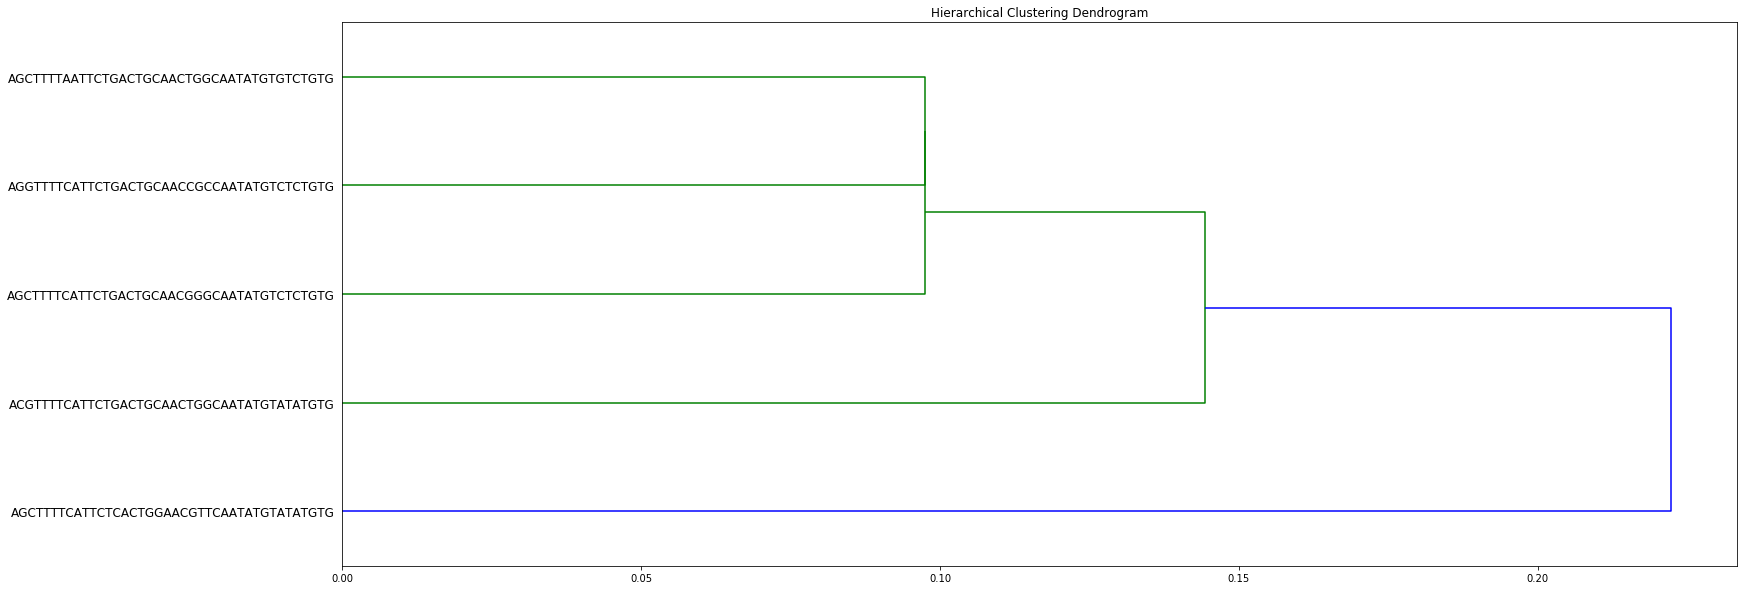

In [426]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')



labelList = list_mutseq_seq

dendrogram(
            linked,
            orientation='right',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True
          )
plt.show()

- Note:
    - That height is the distance between the two subclusters that are merged by that link. 

#### Predict cluster:

__Parameters__:
   - AgglomerativeClustering:
            - linkage: Determine the merging strategy to minimize:
                    - 1) variance of merged clusters ("ward"), 
                    - 2) average of distance between observations from pairs of clusters ("average")
                    - 3) maximum distance between observations from pairs of clusters ("complete").

In [429]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='hamming')
cluster.fit_predict(df_remove_seq)

ValueError: hamming was provided as affinity. Ward can only work with euclidean distances.

### Test

In [ ]:
import scipy.spatial.distance as dis

distances = dis.pdist(df_mutseq_hamming, "hamming")
distances

### Reference:
- Hamming distance: https://people.revoledu.com/kardi/tutorial/Similarity/HammingDistance.html
- Hamming distance: https://github.com/ozcan/scipy-cluster/blob/master/old/cluster.py